# Analysis of the PILS experiments

This notebook is intended to provide a mostly graphical and comprehensive summary of the experiments conducted to study the idea of partly integrated latent space learning for the paired ATACseq and RNAseq data published by Cao et al. (2018).

----

## 0. Environmental setup

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
from IPython.display import Image

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.utils.basic.evaluation import evaluate_partly_integrated_latent_space_paired_data_experiments
import seaborn as sn

---

## 1. Data summary

The data subject to the analyses describes a population of A549 cells to which a DEX treatment was applied. Using the scCAR method the cells were sequenced to obtain the gene expression and DNA activity profiles. In total 1874 cells could be sequenced such that the two different data modalities were recorded at a quality that passed the set standards.

For the ATACseq data 815 transcription factor motifs were derived as described by Cao et al. (2018). To reduce the dimensionality of the gene expression data the subset of genes were selected that showed to be differently expressed with a FWER of less than 5%. The resulting paired data sets hence consist of 1874 cells with 815 features for the ATACseq domain and 2613 features for the RNAseq domain. Both data sets were preprocessed log-transformed:
$$\begin{equation}
    z = log(x+1)
\end{equation}$$
with $x$ being the a raw feature (e.g. some read count for a certain gene) and after that normalized as
$$\begin{equation}
    \hat{z} = \frac{z-z_{med}}{z_{0.75}-z_{0.25}},
\end{equation}$$
where $z_{med}$ is the median of the feature log transformed feature $z$ and $z_{\alpha}$ denotes the $\alpha$-quantile of the empirical distribution of it.

---

## 2. Normal setting

At first the models used in the experiment were designed considering the classical U-shape bias-variance tradeoff setting. Further analyses will extend the analyses to the overparameterized setting to exploit the double-descent characteristic of the validation loss that has been shown to better describe what is empirically seen in many applications in deep learning (see Belkin et al. (2019)). 

### 2a. Basic experimental setup

The following list summarizes the basic setup of the conducted experiments.

| Element | Setting |
| --- | --- |
| Evaluation | 5-fold stratified CV (80-20 train-val split for monitoring) |
|Number of epochs | 1000 |
|Reconstruction loss (weight) | MAE (0.1) |
|Discriminator loss (weight) | Cross-entropy (1.0) |
|Latent structure loss (weight) | Cross-entropy (0.001) |
|Shared latent space ratio | 0.4, 0.8, 1.0 |
|Supervision rate|0, 0.5, 1.0|
|Total latent space size| 50 |

### 2b. Setup of the models

In the following the setups of the models that were used for the experiments are summarized.

#### 2b. i) RNA autoencoder

|Element|Setting|
|---|---|
|Input size| 2613|
|Network type| FCN|
|Hidden layers| 1024, 512, 256, 128, (50), ...|
|Optimizer | RMSprop|
|learning rate| 1e-4|
|regularization| 5e-4 ($l_2$)|

#### 2b. ii) ATAC autoencoder

|Element|Setting|
|---|---|
|Input size| 815|
|Network type| FCN|
|Hidden layers| 512, 256, 128, 64, (50), ...|
|Optimizer | RMSprop|
|learning rate| 1e-4|
|regularization| 5e-4 ($l_2$)|

#### 2b. iii) Latent discriminator

|Element|Setting|
|---|---|
|Input size| shared latent space size|
|Network type| FCN|
|Hidden layers| 128, 128, 128|
|Output size|2|
|Optimizer | RMSprop|
|learning rate| 1e-4|
|regularization| - |

#### 2b iv) Latent classifier

|Element|Setting|
|---|---|
|Input size| shared latent space size|
|Network type| Linear |
|Hidden layers| -|
|Output size|3|
|Optimizer | RMSprop|
|learning rate| 1e-4|
|regularization| - |

---

### 2c. Experimental results

In the following we will summarize the results of the experiments whose setup was described previously.

In [3]:
experiment_dir = '/home/paysan_d/PycharmProjects/domain_translation/data/a549_dex/final_experiments/pils_ls_50/'
reconstruction_results, latent_distance_results, knn_results = \
evaluate_partly_integrated_latent_space_paired_data_experiments(experiment_dir)

#### 2c. i) Reconstruction results

We will first compare the distribution of the reconstruction loss performance for the individual domains to study the effect of the supervision and the ratio of the shared latent space on the reconstruction performance for the individual domains.

As an explanation in the following the term 'shared ratio' will be used to describe the percentage of the dimension being shared for the two data domains, i.e. the number of the dimensions of the latent space that is pushed to be shared by the adversarial training is 
$$dim(\mathcal{Z}) = \textrm{shared ratio} * 50.$$

In [4]:
rna_recon_data = reconstruction_results.loc[reconstruction_results['domain'] == 'rna']
atac_recon_data = reconstruction_results.loc[reconstruction_results['domain'] == 'atac']

##### RNA autoencoder

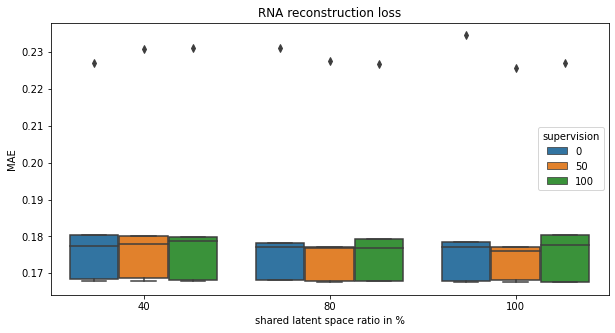

In [5]:
plt.figure(figsize=(10, 5))
ax = plt.axes()
sn.boxplot(x='shared_ratio', y='reconstruction_loss', hue='supervision', data=rna_recon_data, ax=ax)
ax.set_title('RNA reconstruction loss')
ax.set_xlabel('shared latent space ratio in %')
ax.set_ylabel('MAE')
plt.show()

##### ATAC autoencoder

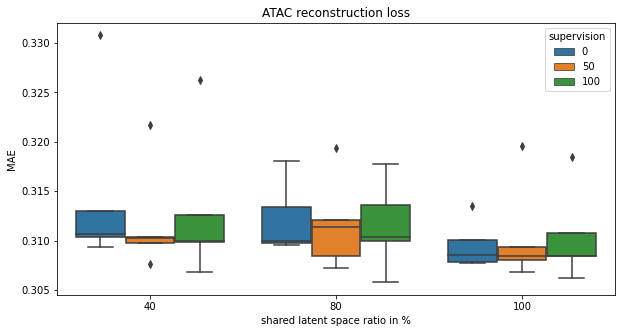

In [6]:
plt.figure(figsize=(10, 5))
ax = plt.axes()
sn.boxplot(x='shared_ratio', y='reconstruction_loss', hue='supervision', data=atac_recon_data, ax=ax)
ax.set_title('ATAC reconstruction loss')
ax.set_xlabel('shared latent space ratio in %')
ax.set_ylabel('MAE')
plt.show()

##### Summary

When analyzing the obtained results for the reconstruction loss the fact that the reconstruction loss seems to be unaffected by change of the ratio of how many dimensions of the latent space are shared is unexpected. Intuitively, we would expect the reconstruction error to be reducing if we allow more freedom to the models to fit a latent space of the same dimensionality. This is because we loosen the constraints on the latent space with respect to its integration. 

However, neither for the RNAseq nor for the ATACseq domain the reconstruction losses differ significantly for the different ratios of shared latent space dimensions. In fact, we actually see that in the case, where all latent dimensions are shared the reconstruction error for the ATAC sequence actually seems to be slightly better.


A possible explanation could be that the lower dimensional manifold in which we aim to embed the two data modalities actually share the vast majority of the dimensions. Thus even if we do not actively enforce the complete integration of the latent spaces the models converge to a solution where the two learned latent spaces are (almost) fully integrated.

However, it is important to mention that the dimensionality of the bottleneck for the two autoencoders is not kept constant but decreases the smaller the fraction of shared latent space dimensions is. This is because we decided to keep the dimensionality of the union of the latent spaces (shared and unshared ones) fixed at 50 for the experiments to better compare the impact of those.

This could also explain why we actually see a small decrease in the ATACseq reconstruction loss for a larger amount of shared data. It is important to keep in mind that however the data is quite variable due to biological variation. Additionally we enforce a (partly) integration of the latent spaces that also limits the solution space and hence influence the reconstruction performance of the learned autoencoders.

##### Implicit integration assumption
To analyze whether the reason for the similar reconstruction performance however is (partly) due to the implicit integration of the learned latent space, i.e. even if not explicitely constrained by the latent discriminator the models more than 50 latent representations are shared among the two data modalities and very informative for the reconstruction of the data.

To get a first impression of that we look at the the correlation structure of the learned latent space features for different levels of shared latent space ratios. To this end we illustrate the learned correlation structure on the training set after 950 epochs of the 4th fold for 40%, 80% and 100% shared latent space dimensions with 0% supervision for the training set, i.e. not using any information about which data samples refer to the same cell during training.

###### Shared latent space ratio 40% (0% supervision)

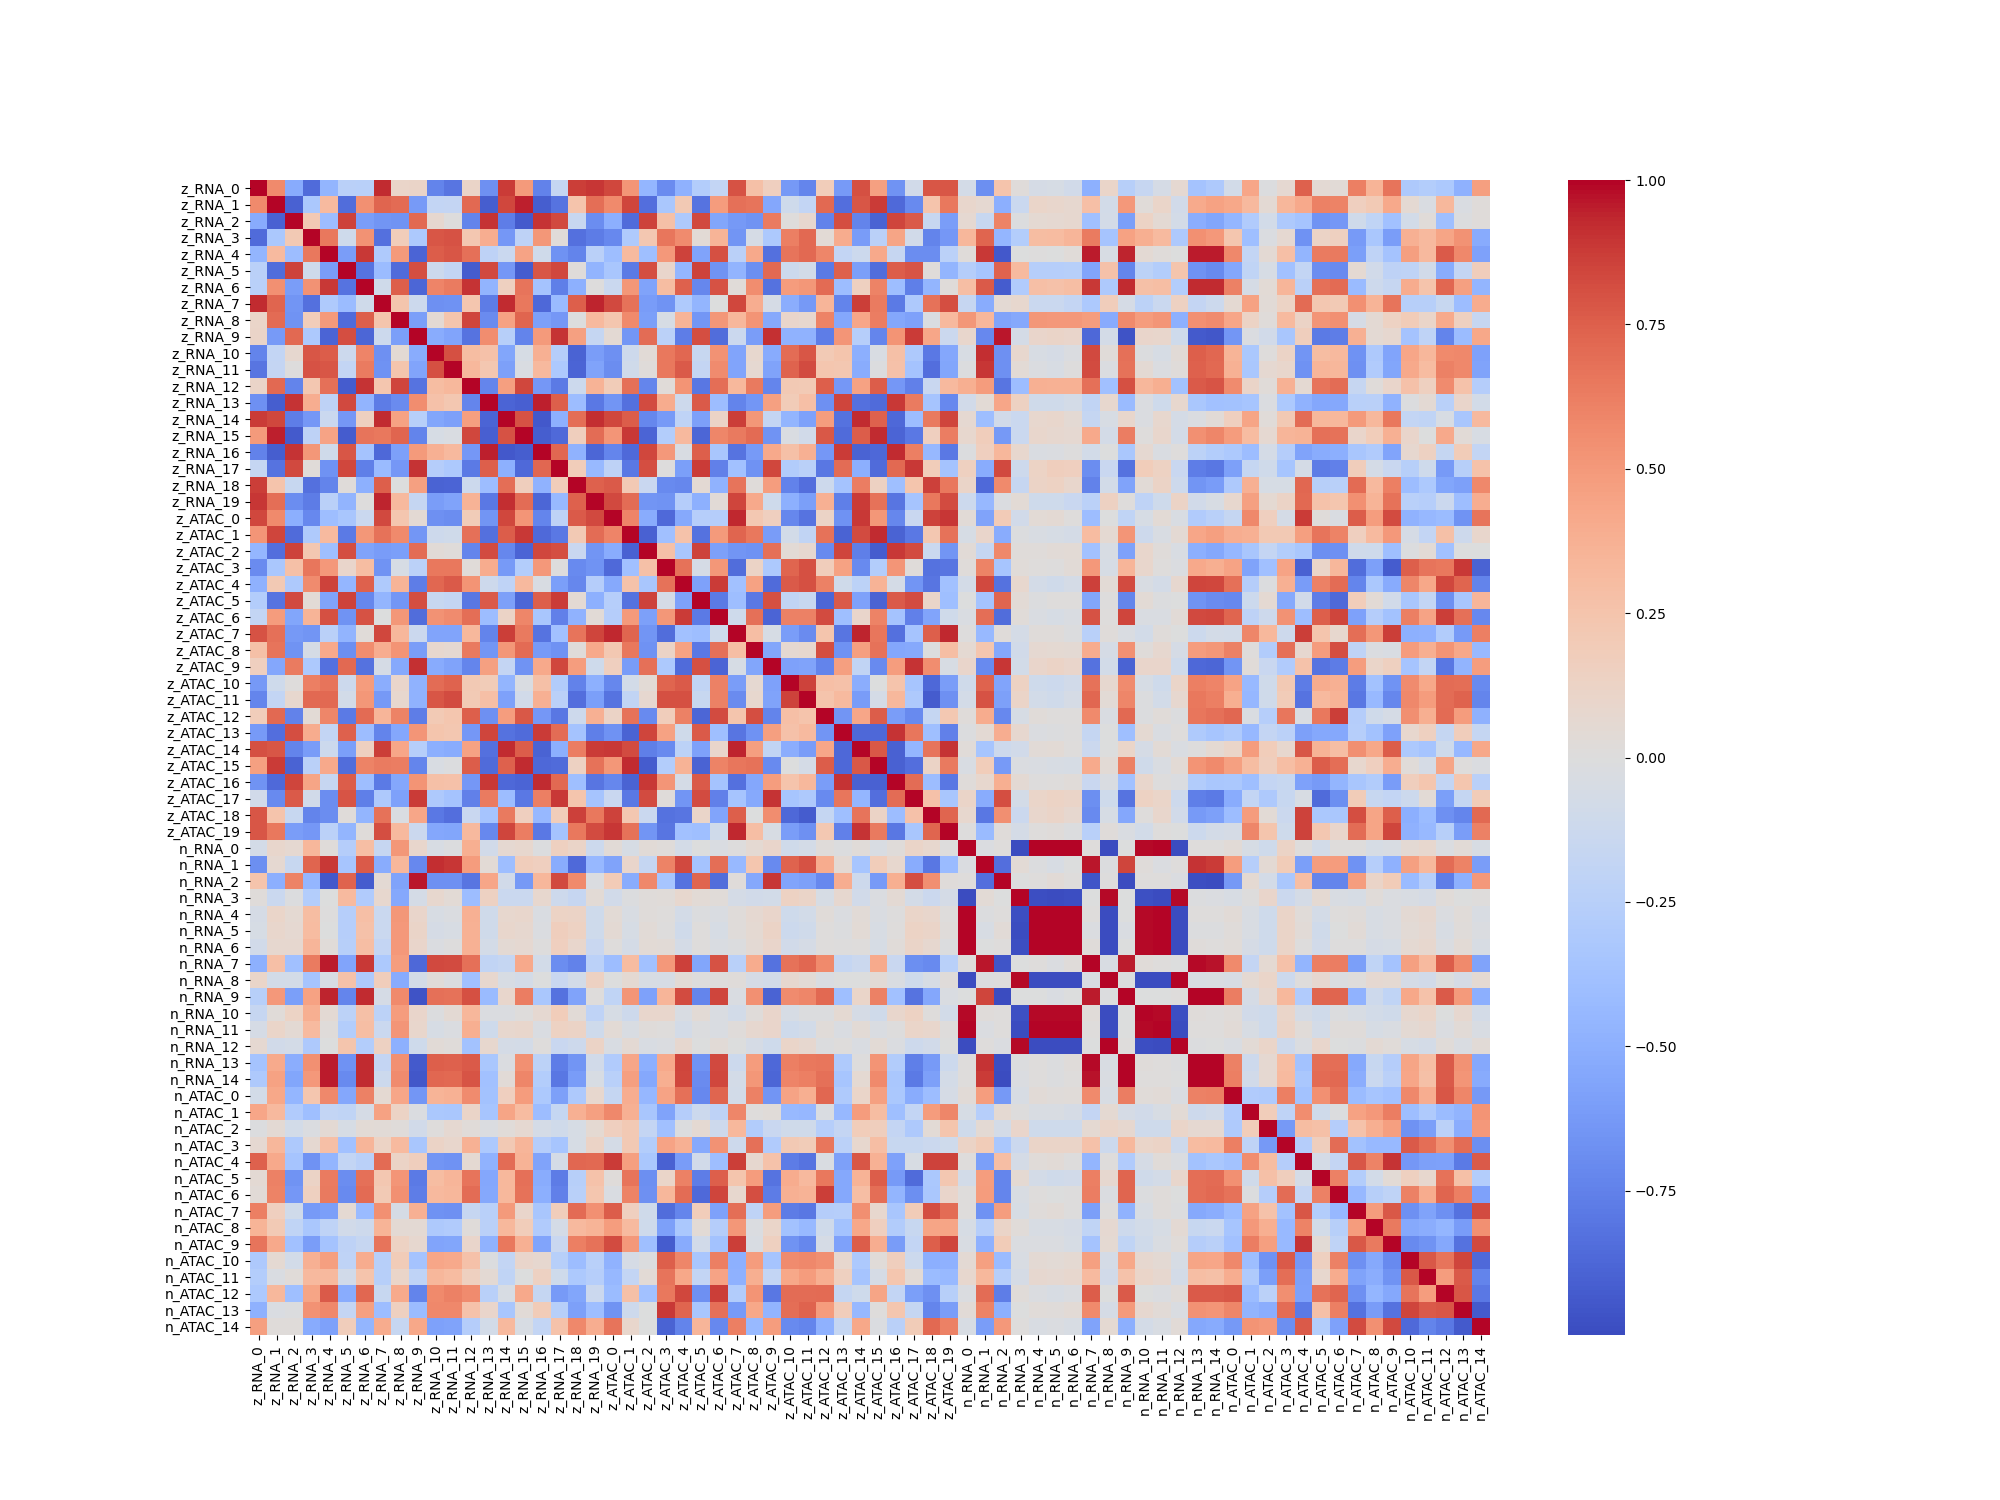

In [7]:
Image(filename=experiment_dir +'40_0/fold_4/epoch_950/latent_space_correlation_structure_train.png', width = 800, height = 600)

###### Shared latent space ratio 80% (0% supervision)

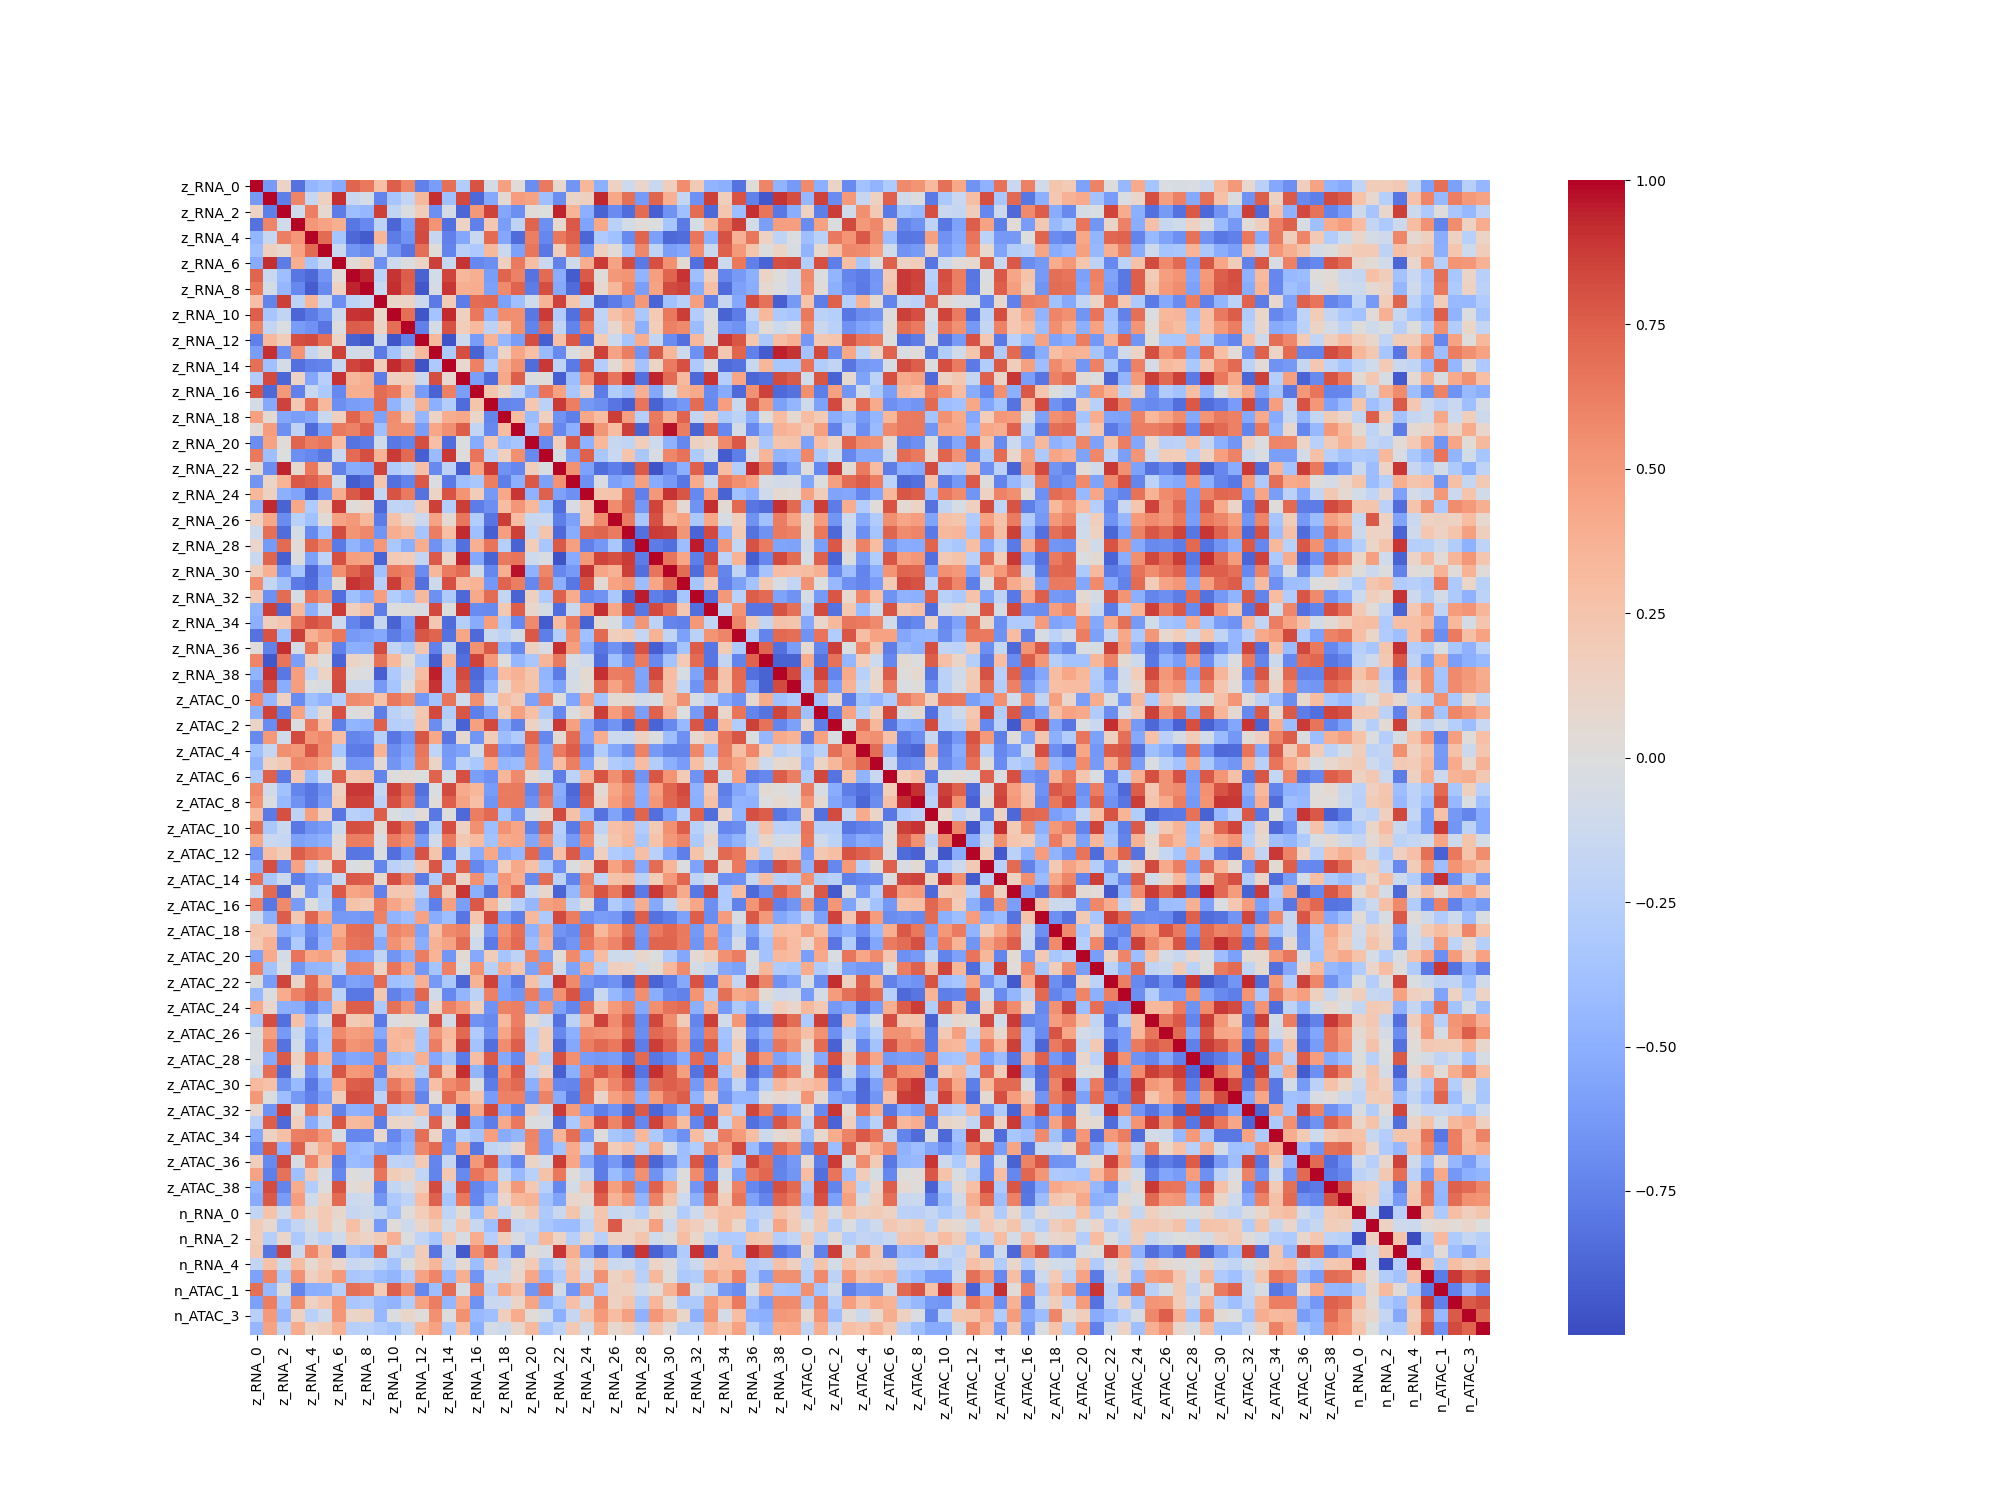

In [8]:
Image(filename=experiment_dir+'80_0/fold_4/epoch_950/latent_space_correlation_structure_train.png', width = 800, height = 600)

First, we the shared latent representations indeed show a similar (slightly less expressed) for the two different data modalities (ATACseq and RNAseq data). This is shown in the above heatmaps by the simialrity of the submatrices illustrating the correlation between any commbination of $z_{ATAC}$ and $z_{RNA}$. Second, we see that even among the unshared dimensions in the latent spaces $n_{RNA_i}, n_{ATAC_i}$ we see a prominent correlation structure with the shared dimensions.

To further validate the assumptions we will increase the dimensions of the latent space substantially. If our assumptions holds true, we should see a decrease of the reconstruction error in that scenario as soon as the size of the latent space exceeds the dimensionality of the true shared latent space of the two data domains. To this end, we increase the dimensions of the latent space to 200 in total and compare the reconstruction performances for a fully shared latent space and a configuration, where only 40% of the latent space dimensions are shared between the two different data modalities.

###### Larger latent space analyses

In [17]:
experiment_dir_large = '/home/paysan_d/PycharmProjects/domain_translation/data/a549_dex/final_experiments/pils_ls_200/'
reconstruction_results_large, _ , _ = \
evaluate_partly_integrated_latent_space_paired_data_experiments(experiment_dir_large)

rna_recon_data_large = reconstruction_results_large.loc[reconstruction_results['domain'] == 'rna']
atac_recon_data_large = reconstruction_results_large.loc[reconstruction_results['domain'] == 'atac']

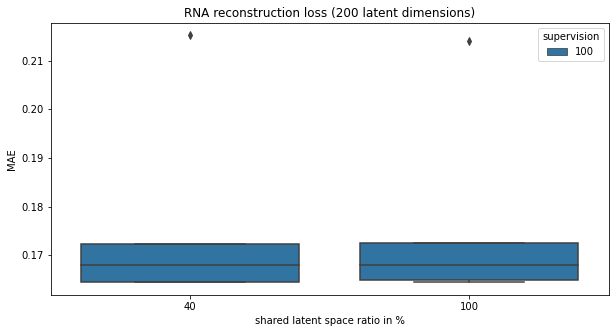

In [18]:
plt.figure(figsize=(10, 5))
ax = plt.axes()
sn.boxplot(x='shared_ratio', y='reconstruction_loss', hue='supervision', data=rna_recon_data_large, ax=ax)
ax.set_title('RNA reconstruction loss (200 latent dimensions)')
ax.set_xlabel('shared latent space ratio in %')
ax.set_ylabel('MAE')
plt.show()

##### ATAC autoencoder

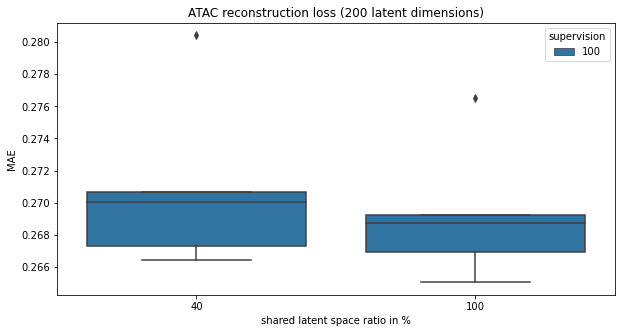

In [19]:
plt.figure(figsize=(10, 5))
ax = plt.axes()
sn.boxplot(x='shared_ratio', y='reconstruction_loss', hue='supervision', data=atac_recon_data_large, ax=ax)
ax.set_title('ATAC reconstruction loss (200 latent dimensions)')
ax.set_xlabel('shared latent space ratio in %')
ax.set_ylabel('MAE')
plt.show()

---

#### 2c. ii) Latent space distance

To get a first impression on how close the paired samples are embedded in the shared latent space for the individual settings of supervision and shared latent space ratio, we analyze the empirical distributions of the $l_1$ distance of the paired samples in the validation folds for the cross-validation procedure. We normalize the $l_1$ distance that is average over the dimensions and samples by the mean distance between any unpaired samples.

The idea of the normalization is to compare the different configurations based on how close the paired samples come and not how close in general the samples come in the latent space measured in the $l_1$ distance.

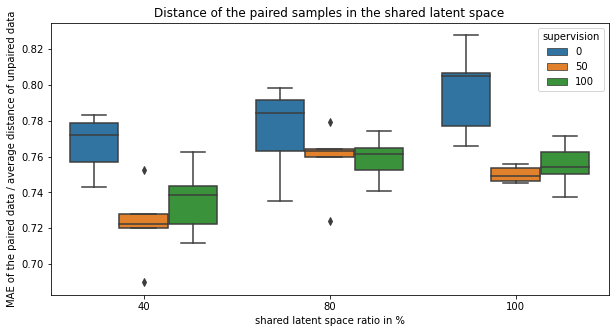

In [12]:
plt.figure(figsize=(10, 5))
ax = plt.axes()
sn.boxplot(x='shared_ratio', y='latent_distance', hue='supervision', data=latent_distance_results, ax=ax)
ax.set_title('Distance of the paired samples in the shared latent space')
ax.set_xlabel('shared latent space ratio in %')
ax.set_ylabel('MAE of the paired data / average distance of unpaired data')
plt.show()

##### Summary

As expected we see a positive effect of supervision on how close the paired data comes in the latent space. However, we do not see a statisically significant differences between the distance of the paired samples in the latent space between a supervision ratio of $50%$ and $100%$. In absolute value however, we see that the more supervision is applied the closer the cells come in the latent space measured in the unnormalized $l_1$-distances.

Surprisingly, we see that the paired samples in the smallest latent space are closer together than for the configurations using larger dimensional latent spaces. However, one must keep in mind that the comparison of distances in different dimensions is not a good practice even after applying a normalization taking that into account.

As a consequence it very well may be that this is simply an artifact due to the course of dimensionality.

---

#### 2c. iii) kNN accuracy

Finally, we will evaluate the different settings with respect to the knn-accuracy that is defined as

$$
\textrm{kNN accuracy}(A,B) = \frac{\sum\limits_{(x,y) \in A\times B}1[z_x \in \mathcal{K}^z_y]}{n},
$$

where $n$ is the size of the data sets $A$ and $B$ of the two domains and $\mathcal{K}^z_y$ describes the set of k-nearest neighbors of the latent representation of the sample $y$ and $z_x$ is the latent representation (in the shared latent space) of the sample $x$.

Since this metric is not necessarily symmetric we take the unweighted average for our analysis.

In [13]:
knn_results['supervision'] = knn_results['supervision'].astype('category')

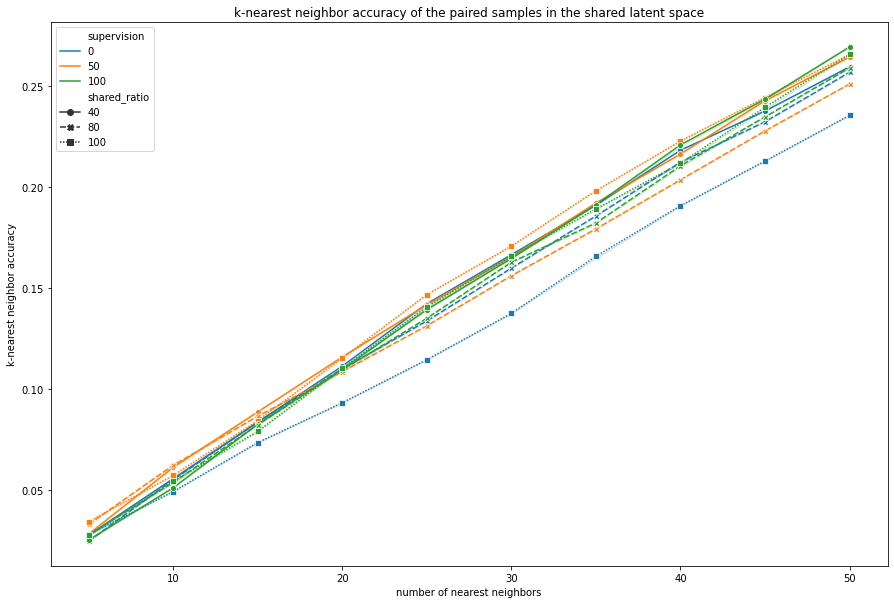

In [14]:
plt.figure(figsize=(15, 10))
ax = plt.axes()
sn.lineplot(x="k", y="knn_accuracy", hue="supervision", style='shared_ratio', data=knn_results, ci=0, 
            markers=True,ax=ax)
ax.set_title('k-nearest neighbor accuracy of the paired samples in the shared latent space')
ax.set_xlabel('number of nearest neighbors')
ax.set_ylabel('k-nearest neighbor accuracy')
plt.show()

##### Summary

The key takeaway message of the kNN accuracy results is that there are no clear statistical differences between different experimental configuration. However, we see some trends with respect to the level of supervision. It seems that in general supervision seems to improve the kNN accuracy as expected. However, we see that especially for smaller numbers of $k$ the accuracy is slightly higher for a supervision level of 50% than for a supervision level of 100%. 

This is consistent with what we observe for the normalized distance of the paired samples in the latent space. The closer a sample is to its partner and at the same time the farer it is from the other samples, the larger the kNN accuracy will be especially for small $k$. For a large enough $k$ this effect diminishes and we actually see that the performance of the models trained in a fully supervised setting slightly outperform those trained in a partly or unsupervised setting.

Unexpectedly, we see that the autoencoders using a shared latent space of 40 dimensions (80% of the total latent space size) seems to perform worse with respect to the kNN accuracy than both the ones using a smaller (40%) and larger (100%) shared latent space. A possible explanation could be that interplay of the sensitivity of the kNN accuracy to the dimensionality of the shared latent space and the similarity of the data modalities as discussed previously.